This notebook runs the most simple simulation but uses a deep q network with experience replay buffer and target network

In [74]:
from agent import CircleUser, SimpleAgent
from gridworld import GridWorld
from datastructures import PERBuffer

from collections import deque
from random import choice
import json
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch

DQN class

In [75]:
class SensorDQAgent:
    def __init__(self,cfg):
        self.rbuffer = PERBuffer(cfg['buffer_size'], cfg['buffer_alpha'], cfg['buffer_beta'], cfg['trajectory_length'])
        self.batch_size = cfg['batch_size']
        self.gamma = cfg['gamma']

        self.action_space = ((1,0),(0,1))
        
        self.target_update_interval = cfg['target_update_interval']
        self.t = 0

        self.epsilon = cfg['epsilon']
        self.epsilon_decay = cfg['epsilon_decay']
        self.epsilon_min = cfg['epsilon_min']

        self.net = torch.nn.Sequential(
            torch.nn.Linear(cfg['trajectory_length'], cfg['nhidden']),
            torch.nn.BatchNorm1d(cfg['nhidden']),
            torch.nn.ReLU(),
            torch.nn.Linear(cfg['nhidden'], cfg['nhidden']),
            torch.nn.BatchNorm1d(cfg['nhidden']),
            torch.nn.ReLU(),
            torch.nn.Linear(cfg['nhidden'], 2)
        )
        self.target = torch.nn.Sequential(
            torch.nn.Linear(cfg['trajectory_length'], cfg['nhidden']),
            torch.nn.BatchNorm1d(cfg['nhidden']),
            torch.nn.ReLU(),
            torch.nn.Linear(cfg['nhidden'], cfg['nhidden']),
            torch.nn.BatchNorm1d(cfg['nhidden']),
            torch.nn.ReLU(),
            torch.nn.Linear(cfg['nhidden'], 2)
        )

        self.target.load_state_dict(self.net.state_dict())

        self.lossf = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=cfg['alpha'])
    
    def policy(self, state):
        if len(state.shape) == 1:
            state = torch.tensor(state).unsqueeze(0)

        if np.random.random() < self.epsilon:
            return choice(self.action_space)
        else:
            self.net.eval()
            return self.action_space[torch.argmax(self.net(state))]

    def max_action(self, state):
        if len(state.shape) == 1:
            state = torch.tensor(state).unsqueeze(0)

        self.net.eval()
        return self.action_space[torch.argmax(self.net(state))]
    
    def update(self, s,a,r,s_,done):
        self.net.train()
        self.rbuffer.add(s, a, r, s_)

        transitions = self.rbuffer.sample(self.batch_size)

        q_values = self.net(transitions['obs'])
        next_q_values = self.target(transitions['next_obs'])
        target_q_values = [reward + self.gamma * torch.max(next_q_values[i]) for i, reward in enumerate(transitions['reward'])]

        td_error = [self.lossf(q_values[i][action[1]], target_q_values[i]) for i, action in enumerate(transitions['action'])]        
        loss = torch.stack(td_error).mean()
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.t % self.target_update_interval:
            self.target.load_state_dict(self.net.state_dict())
        self.t += 1
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

config

In [76]:
cfg_values = [0,0.2,0.4,0.6,0.8,1]
cfg_name = 'w2'


cfg = {
        # agent
        'agent': 'SensorDQAgent',
        'ds': 'lambda x: torch.tensor(x,dtype=torch.float32)',
        'nhidden': 64,

        'buffer_size': 10000,
        'buffer_alpha': 1,
        'buffer_beta': 0.4,
        'target_update_interval': 200,

        'batch_size': 64,
        'alpha': 0.01,
        'gamma': 0.9,
        'epsilon': 1,
        'epsilon_decay': 0.999,
        'epsilon_min': 0.1,
        
        # env
        'trajectory_length': 10, # 5 positions of size 2
        'coverage_window': 16,
        'exact_position': False,
        'w1': 1,
        'w2': 0.1,

        'n_episodes': 20,
        'test_every': '',
        'n_test_episodes': 50,
        'ep_len': 100,
        'start': (0,0),
        'goal': (0,0),
        'wait_time': 3,
        'move_probability': 0.5,
        'grid': [['-' for j in range(5)] for i in range(5)],
        'name': '',
        'var' : '',

        'save_path': 'results/DQN_easy/',
}
cfg['epsilon_decay'] = cfg['epsilon_min'] ** (1/cfg['n_episodes'])
cfg['test_every'] = cfg['n_episodes'] // 20

if cfg['save_path']:
    with open(cfg['save_path']+ 'config.json', 'w+') as f:
        json.dump(cfg, f)

cfg['agent'] = eval(cfg['agent'])
cfg['ds'] = eval(cfg['ds'])


sim episode

In [77]:
def sim_episode(episode, agent, cfg, train):
    trajectory = deque([0]*cfg['trajectory_length'],maxlen=cfg['trajectory_length'])
    coverage_window = deque(maxlen=cfg['coverage_window'])
    covered_states = deque(maxlen=cfg['coverage_window'])
    sensor_usage = deque(maxlen=cfg['coverage_window'])
    sensed = set()
    visited = set()
    activation_count = 0
    ep_reward = 0
    r_0 = 0
    r_1 = 0

    for t,position in enumerate(episode):
        visited.add(position)
        s = cfg['ds'](trajectory)
        action = agent.policy(s)

        if action[1]: #give agent knowledge of position if sensor was activated
            sensed.add(position)
            sensor_usage.append(1)
            if position not in covered_states:
                coverage_window.append(1)
            else:
                coverage_window.append(0)
            covered_states.append(position)
            coverage_window.append(1)
            activation_count +=1
            trajectory.append(position[0])
            trajectory.append(position[1])
        elif cfg['exact_position']:
            trajectory.append(position[0])
            trajectory.append(position[1])
            coverage_window.append(0)
        else:
            trajectory.append(-1)
            trajectory.append(-1)
            coverage_window.append(0)
            sensor_usage.append(0)

        r = cfg['w1'] * sum(coverage_window)/len(coverage_window) - cfg['w2']* action[1]
        s_ = cfg['ds'](trajectory)
        ep_reward += r
        if train:
            agent.update(s, action[1], r, s_, position != cfg['goal'])
    return ep_reward, activation_count

In [78]:
def generate_training_data(env, user, n_episodes, ep_length):
    data = []
    
    for i in range(n_episodes):
        trajectory = [env.start]
        env.reset()
        user.reset()
        for j in range(ep_length):
            action = user.policy()
            newX = env.agent_location[0] + action[0]
            newY = env.agent_location[1] + action[1]
            trajectory.append((newX,newY))
            env.move_agent(newX, newY)
            if env.is_terminal():
                break
        data.append(trajectory)

    return data

In [79]:
def load_and_test(cfg,model_path):
    env = GridWorld(cfg['start'], cfg['goal'], cfg['grid'])
    user = CircleUser(cfg) 
    test_data = generate_training_data(env, user, cfg['n_test_episodes'], cfg['ep_len'])
    baseline_agent = SimpleAgent() 
    agent = cfg['agent'](cfg)
    agent.net.load_state_dict(torch.load(model_path))
    test_data = generate_training_data(env, user, cfg['n_test_episodes'],cfg['ep_len'])
    test_r = 0
    test_usage = 0
    base_test_r = 0
    base_test_usage = 0
    for episode in (test_data):
        r, usg = sim_episode(episode, agent, cfg, False)
        base_r, base_usg = sim_episode(episode, baseline_agent, cfg, False)
        base_test_r += base_r
        test_r+= r
        test_usage +=(usg/len(episode))
        base_test_usage += (base_usg/len(episode))

    test_r/=cfg['n_test_episodes']
    test_usage/=cfg['n_test_episodes']
    base_test_r/=cfg['n_test_episodes']
    base_test_usage/=cfg['n_test_episodes']
    return{
        'test_reward': test_r,
        'baseline_test_reward': base_test_r,
        'sensor_usage': test_usage,
        'baseline_sensor_usage': base_test_usage,
        'name': 'w2=0',
        'var': 'w2'
    }



In [80]:
def simple_moving_average(data, window_size):
    if len(data) < window_size:
        raise ValueError("Data size must be greater than or equal to the window size.")

    # Use the 'valid' mode to ensure that output size is the same as input size
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')



train

In [81]:
def train(cfg, cfg_values):
    results = []
    for cfg_value in cfg_values:
        cfg[cfg_name] = cfg_value
        cfg['name'] = f'{cfg_name}={cfg_value}'
        env = GridWorld(cfg['start'], cfg['goal'], cfg['grid'])

        user = CircleUser(cfg) 
        train_data = generate_training_data(env, user, cfg['n_episodes'], cfg['ep_len'])
        baseline_agent = SimpleAgent() 
        agent = cfg['agent'](cfg)

        base_train_rs = []
        train_rs = []

        test_rs = []
        test_usages = []
        base_test_rs = []
        base_test_usages = []

        for n, episode in enumerate(tqdm(train_data)):
            train_r, activation_count = sim_episode(episode, agent, cfg, True)
            base_train_r,_ = sim_episode(episode, baseline_agent, cfg, True)

            train_rs.append(train_r)
            base_train_rs.append(base_train_r)

            if not n % cfg['test_every']:
                test_r = 0
                test_usage = 0
                base_test_r = 0
                base_test_usage = 0
                test_data = generate_training_data(env, user, cfg['n_test_episodes'],cfg['ep_len'])
                for episode in (test_data):
                    r, usg = sim_episode(episode, agent, cfg, False)
                    base_r, base_usg = sim_episode(episode, baseline_agent, cfg, False)
                    base_test_r += base_r
                    test_r+= r
                    test_usage +=(usg/len(episode))
                    base_test_usage += (base_usg/len(episode))

                test_rs.append(test_r/cfg['n_test_episodes'])
                test_usages.append(test_usage/cfg['n_test_episodes'])
                base_test_rs.append(base_test_r/cfg['n_test_episodes'])
                base_test_usages.append(base_test_usage/cfg['n_test_episodes'])



        if cfg['save_path']:
            torch.save(agent.net.state_dict(), cfg['save_path'] + cfg['name'] + 'final.pt')
        # test
        test_data = generate_training_data(env, user, cfg['n_test_episodes'],cfg['ep_len'])
        test_r = 0
        test_usage = 0
        base_test_r = 0
        base_test_usage = 0
        for episode in (test_data):
            r, usg = sim_episode(episode, agent, cfg, False)
            base_r, base_usg = sim_episode(episode, baseline_agent, cfg, False)
            base_test_r += base_r
            test_r+= r
            test_usage +=(usg/len(episode))
            base_test_usage += (base_usg/len(episode))

        test_rs.append(test_r/cfg['n_test_episodes'])
        test_usages.append(test_usage/cfg['n_test_episodes'])
        base_test_rs.append(base_test_r/cfg['n_test_episodes'])
        base_test_usages.append(base_test_usage/cfg['n_test_episodes'])
        results.append({
            'train_rewards': train_rs,
            'baseline_train_rewards': base_train_rs,
            'test_rewards': test_rs,
            'baseline_test_rewards': base_test_rs,
            'sensor_usages': test_usages,
            'baseline_sensor_usages': base_test_usages,
            'name': cfg['name'],
            'var': cfg['var']
        })
    return results

In [82]:
dqn_results = train(cfg, cfg_values)
with open(cfg['save_path']+'results.json', 'w') as f:
    json.dump(dqn_results, f)

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\joe\AppData\Local\Temp\ipykernel_28852\1906201408.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)


100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Training results

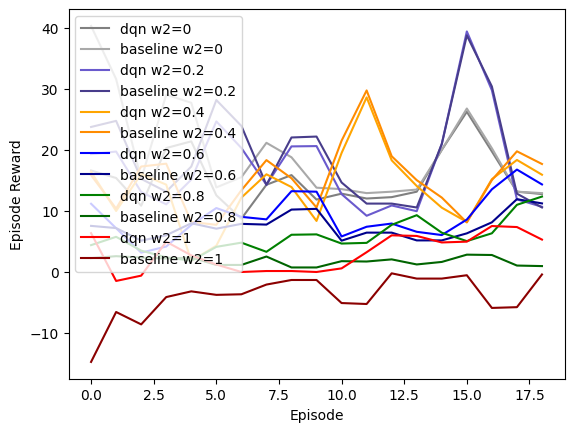

In [83]:
colors = ['red', 'green', 'blue', 'orange', 'slateblue', 'gray']
with open('results/DQN/results.json', 'r') as f:
    dqn_results = json.load(f)
    for result in dqn_results:
        color =  colors.pop()
        plt.plot(simple_moving_average(result['train_rewards'],int(len(result['train_rewards'])/10)), 
                label=f'dqn {result["name"]}',color=color)
        plt.plot(simple_moving_average(result['baseline_train_rewards'],int(len(result['train_rewards'])/10)),
                label=f'baseline {result["name"]}',color='dark'+color)
        plt.legend()
        plt.xlabel('Episode')
        plt.ylabel(f'Episode Reward')
        if cfg['save_path']:
            plt.savefig(f'{cfg["save_path"]}{result["name"]}_train.png')

Test results

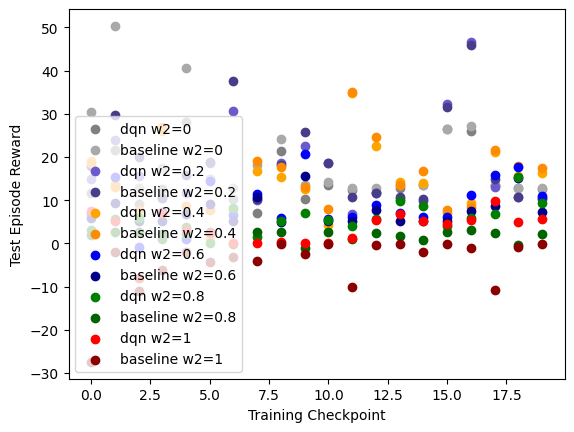

In [89]:
colors = ['red', 'green', 'blue', 'orange', 'slateblue', 'gray']
with open('results/DQN/results.json', 'r') as f:
    dqn_results = json.load(f)
    for result in dqn_results:
        color = colors.pop()
        plt.scatter(result['train_rewards'], label=f'dqn {result["name"]}',color=color)
        plt.scatter(result['baseline_train_rewards'], label=f'baseline {result["name"]}',color='dark'+color)
        plt.legend()
        plt.xlabel('Training Checkpoint')
        plt.ylabel(f'Test Episode Reward')
        if cfg['save_path']:
            plt.savefig(f'{cfg["save_path"]}{result["name"]}_train.png')
